# Proyek Klasifikasi Gambar: Vegetable Images
- **Nama:** Moh. Novil Maarij
- **Email:** mohnovil.22134@mhs.unesa.ac.id
- **ID Dicoding:** nofeel

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import cv2
from skimage import io, img_as_ubyte



# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder


# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

### Data Preprocessing

In [6]:
def cek_jumlah_kelas(dataset_path):

    kelas = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]


    print("Daftar kelas:")
    for kelas_name in kelas:
        print("{}. {}".format(kelas.index(kelas_name), kelas_name))


    print(f"\nJumlah kelas: {len(kelas)}")


dataset_path = '/content/Vegetable Images/test'
cek_jumlah_kelas(dataset_path)


Daftar kelas:
0. Brinjal
1. Broccoli
2. Bitter_Gourd
3. Cauliflower
4. Bottle_Gourd
5. Pumpkin
6. Capsicum
7. Cucumber
8. Carrot
9. Tomato
10. Potato
11. Papaya
12. Radish
13. Bean
14. Cabbage

Jumlah kelas: 15


In [27]:
import os

def hitung_jumlah_gambar(folder_path):
    total_gambar = 0
    # Menelusuri subfolder yang mewakili kelas
    for kelas_folder in os.listdir(folder_path):
        kelas_path = os.path.join(folder_path, kelas_folder)

        # Pastikan hanya folder yang diproses
        if os.path.isdir(kelas_path):
            gambar_files = [f for f in os.listdir(kelas_path) if f.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
            total_gambar += len(gambar_files)
    return total_gambar

# Path folder
train_path = '/content/Vegetable Images/train'
val_path = '/content/Vegetable Images/validation'
test_path = '/content/Vegetable Images/test'

# Menghitung jumlah gambar di setiap folder (termasuk subfolder kelas)
jumlah_train = hitung_jumlah_gambar(train_path)
jumlah_val = hitung_jumlah_gambar(val_path)
jumlah_test = hitung_jumlah_gambar(test_path)

# Menampilkan hasil
print(f"Jumlah gambar di folder train: {jumlah_train}")
print(f"Jumlah gambar di folder validation: {jumlah_val}")
print(f"Jumlah gambar di folder test: {jumlah_test}")


Jumlah gambar di folder train: 15000
Jumlah gambar di folder validation: 3000
Jumlah gambar di folder test: 3000


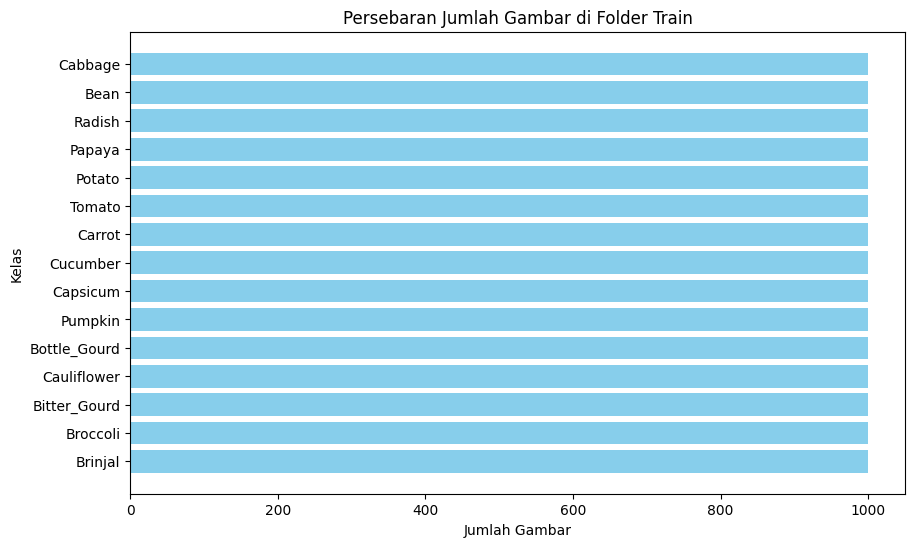

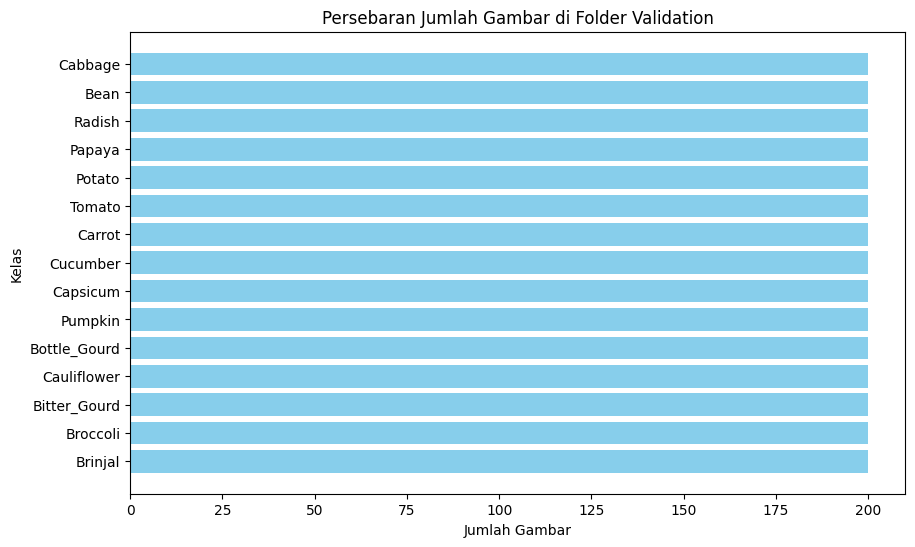

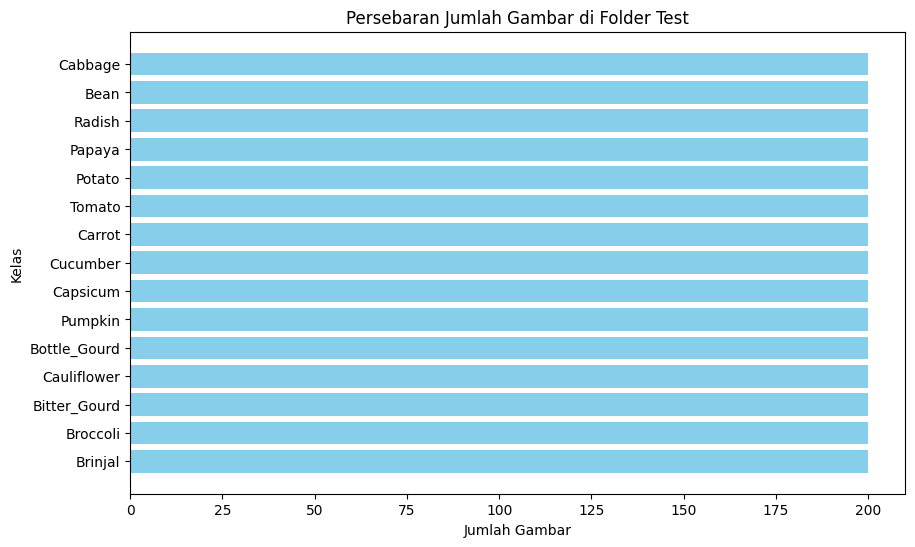

In [28]:
import os
import matplotlib.pyplot as plt

def hitung_jumlah_gambar_per_kelas(folder_path):
    kelas_dict = {}
    # Menelusuri subfolder yang mewakili kelas
    for kelas_folder in os.listdir(folder_path):
        kelas_path = os.path.join(folder_path, kelas_folder)

        # Pastikan hanya folder yang diproses
        if os.path.isdir(kelas_path):
            gambar_files = [f for f in os.listdir(kelas_path) if f.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
            kelas_dict[kelas_folder] = len(gambar_files)
    return kelas_dict

# Path folder
train_path = '/content/Vegetable Images/train'
val_path = '/content/Vegetable Images/validation'
test_path = '/content/Vegetable Images/test'

# Menghitung jumlah gambar per kelas di setiap folder
train_kelas = hitung_jumlah_gambar_per_kelas(train_path)
val_kelas = hitung_jumlah_gambar_per_kelas(val_path)
test_kelas = hitung_jumlah_gambar_per_kelas(test_path)

# Fungsi untuk menampilkan grafik distribusi gambar per kelas
def plot_distribusi_gambar(kelas_dict, folder_name):
    kelas = list(kelas_dict.keys())
    jumlah_gambar = list(kelas_dict.values())

    plt.figure(figsize=(10, 6))
    plt.barh(kelas, jumlah_gambar, color='skyblue')
    plt.xlabel('Jumlah Gambar')
    plt.ylabel('Kelas')
    plt.title(f'Persebaran Jumlah Gambar di Folder {folder_name}')
    plt.show()

# Menampilkan grafik untuk masing-masing folder
plot_distribusi_gambar(train_kelas, "Train")
plot_distribusi_gambar(val_kelas, "Validation")
plot_distribusi_gambar(test_kelas, "Test")


Daftar kelas:
1. Brinjal


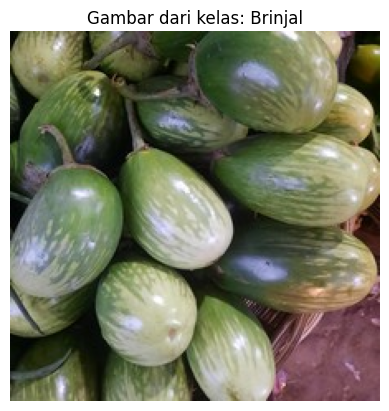

2. Broccoli


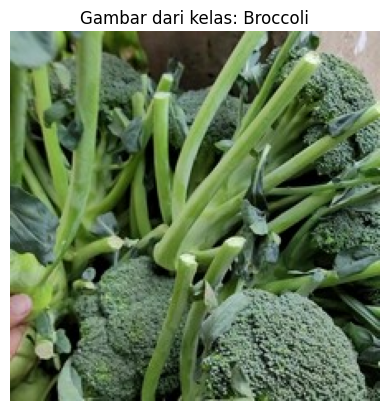

3. Bitter_Gourd


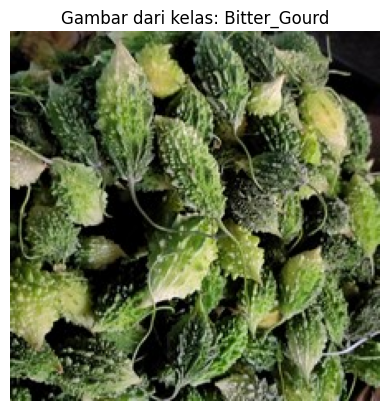

4. Cauliflower


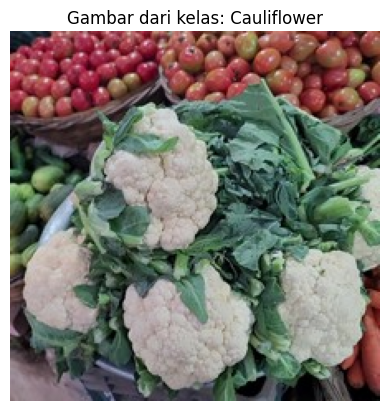

5. Bottle_Gourd


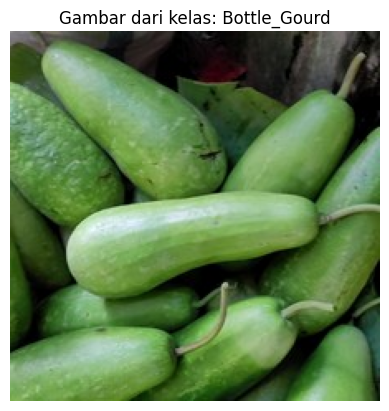

6. Pumpkin


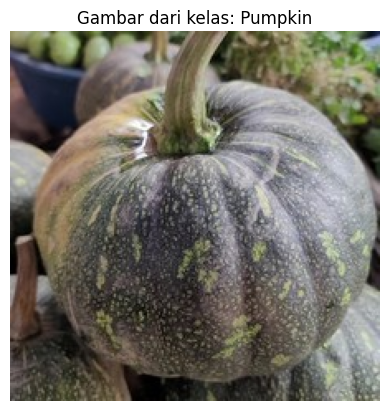

7. Capsicum


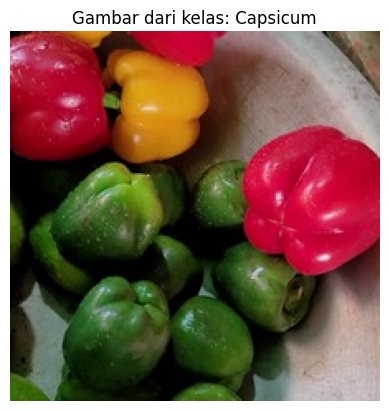

8. Cucumber


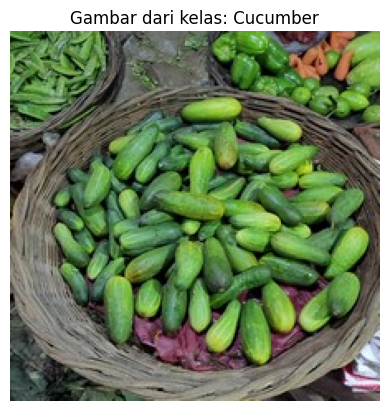

9. Carrot


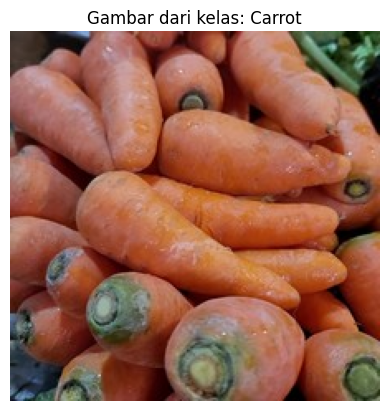

10. Tomato


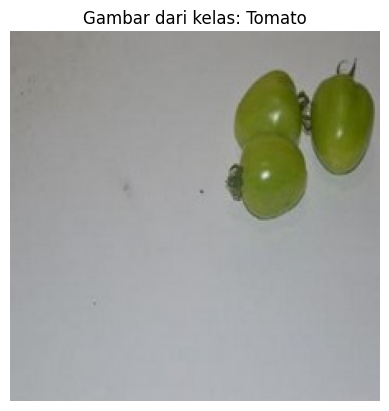

11. Potato


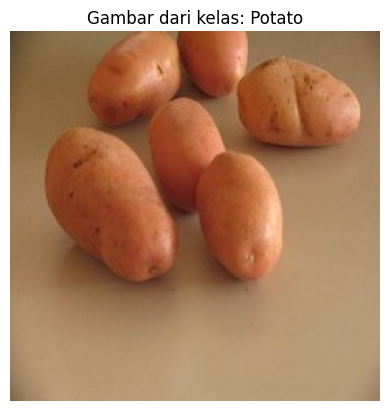

12. Papaya


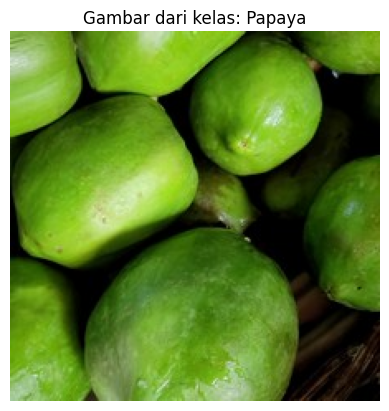

13. Radish


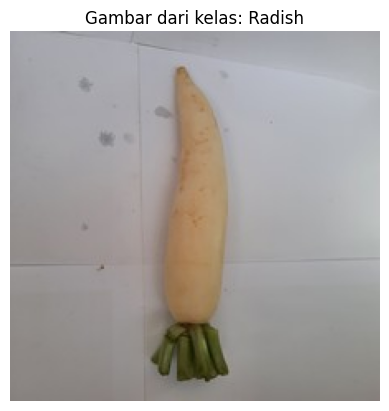

14. Bean


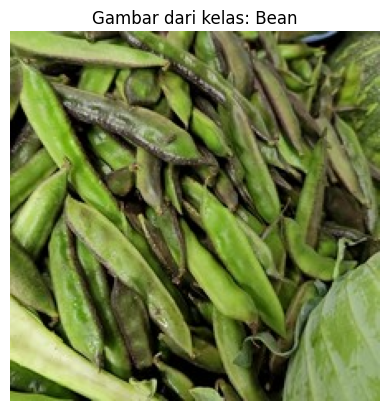

15. Cabbage


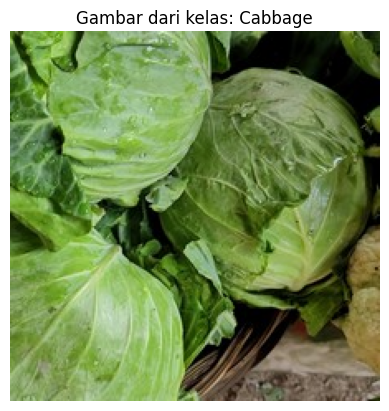

In [7]:
def tampilkan_gambar_per_kelas(dataset_path):

    kelas = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

    print("Daftar kelas:")


    for kelas_name in kelas:

        print("{}. {}".format(kelas.index(kelas_name) + 1, kelas_name))

        kelas_folder_path = os.path.join(dataset_path, kelas_name)
        gambar_files = os.listdir(kelas_folder_path)

        gambar_file = next((f for f in gambar_files if f.lower().endswith(('jpg', 'png'))), None)

        if gambar_file:
            gambar_path = os.path.join(kelas_folder_path, gambar_file)
            img = mpimg.imread(gambar_path)

            plt.imshow(img)
            plt.title(f"Gambar dari kelas: {kelas_name}")
            plt.axis('off')
            plt.show()


dataset_path = '/content/Vegetable Images/test'
tampilkan_gambar_per_kelas(dataset_path)


In [8]:
def cek_ukuran_gambar(dataset_path):
    kelas = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

    print("Daftar kelas dan ukuran gambar:")

    for kelas_name in kelas:
        print(f"\nKelas: {kelas_name}")

        kelas_folder_path = os.path.join(dataset_path, kelas_name)
        gambar_files = os.listdir(kelas_folder_path)

        gambar_file = next((f for f in gambar_files if f.lower().endswith(('jpg', 'png'))), None)

        if gambar_file:
            gambar_path = os.path.join(kelas_folder_path, gambar_file)

            with Image.open(gambar_path) as img:
                width, height = img.size

            print(f"Ukuran gambar {gambar_file}: {width}x{height} (Lebar x Tinggi)")

dataset_path = '/content/Vegetable Images/test'
cek_ukuran_gambar(dataset_path)


Daftar kelas dan ukuran gambar:

Kelas: Brinjal
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Broccoli
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Bitter_Gourd
Ukuran gambar 1247.jpg: 224x224 (Lebar x Tinggi)

Kelas: Cauliflower
Ukuran gambar 1247.jpg: 224x224 (Lebar x Tinggi)

Kelas: Bottle_Gourd
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Pumpkin
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Capsicum
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Cucumber
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Carrot
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Tomato
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Potato
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Papaya
Ukuran gambar 1247.jpg: 224x224 (Lebar x Tinggi)

Kelas: Radish
Ukuran gambar 1178.jpg: 224x224 (Lebar x Tinggi)

Kelas: Bean
Ukuran gambar 0711.jpg: 224x224 (Lebar x Tinggi)

Kelas: Cabbage
Ukuran gambar 1178.jpg: 224x224 (

In [10]:
train_path = '/content/Vegetable Images/train'
val_path = '/content/Vegetable Images/validation'
test_path = '/content/Vegetable Images/test'

seed_r = tf.random.set_seed(42)
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode="categorical",
    seed=seed_r
)

val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=32,
    class_mode="categorical",
    seed=seed_r
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Modelling

In [12]:
model_sayur = Sequential()

model_sayur.add(Conv2D(filters=20, kernel_size=(3, 3), activation="relu", input_shape=(224, 224, 3)))
model_sayur.add(Conv2D(20, (3, 3), activation="relu"))
model_sayur.add(MaxPool2D((2, 2), padding="valid"))

model_sayur.add(Conv2D(50, (3, 3), activation="relu"))
model_sayur.add(Conv2D(50, (3, 3), activation="relu"))
model_sayur.add(MaxPool2D((2, 2)))

model_sayur.add(Flatten())
model_sayur.add(Dropout(0.5))

model_sayur.add(Dense(15, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:

# Callback: Stop jika akurasi training >= 95%
class StopAtAccuracy(Callback):
    def __init__(self, threshold=0.95):
        super(StopAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        if acc is not None and acc >= self.threshold:
            print(f"\n🎯 Akurasi training sudah mencapai {acc*100:.2f}%, menghentikan training otomatis.")
            self.model.stop_training = True

# Callback: Stop kalau val_accuracy stagnan (tidak naik) dalam 5 epoch
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Gabungkan callback
mycallback = [StopAtAccuracy(threshold=0.95), early_stop]

In [14]:
labels_train = train_data.classes
# Menghitung bobot kelas menggunakan fungsi class_weight dari sklearn
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)

# Membuat dictionary untuk class weights
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [20]:
# compiling model
model_sayur.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

model_sayur.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 20)   │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 50)   │         9,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 50)   │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 140450)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 140450)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │     2,106,765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,142,545 (8.17 MB)

 Trainable params: 2,142,545 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history_1 = model_sayur.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        callbacks=mycallback,
        class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 417ms/step - accuracy: 0.3901 - loss: 1.8070 - val_accuracy: 0.7297 - val_loss: 0.8743
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 395ms/step - accuracy: 0.7017 - loss: 0.9214 - val_accuracy: 0.7937 - val_loss: 0.6269
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 393ms/step - accuracy: 0.7889 - loss: 0.6585 - val_accuracy: 0.8507 - val_loss: 0.4357
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 395ms/step - accuracy: 0.8174 - loss: 0.5879 - val_accuracy: 0.8717 - val_loss: 0.3919
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 393ms/step - accuracy: 0.8321 - loss: 0.5250 - val_accuracy: 0.9163 - val_loss: 0.2668
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 397ms/step - accuracy: 0.8640 - loss: 0.4291 - val_accuracy: 0.9163 - val_loss: 0.2634
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 399ms/step - accuracy: 0.8667 - loss: 0.4270 - val_accuracy: 0.9307 - val_loss: 0.2286
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 395ms/step - accuracy: 0.8800 -

## Evaluasi dan Visualisasi

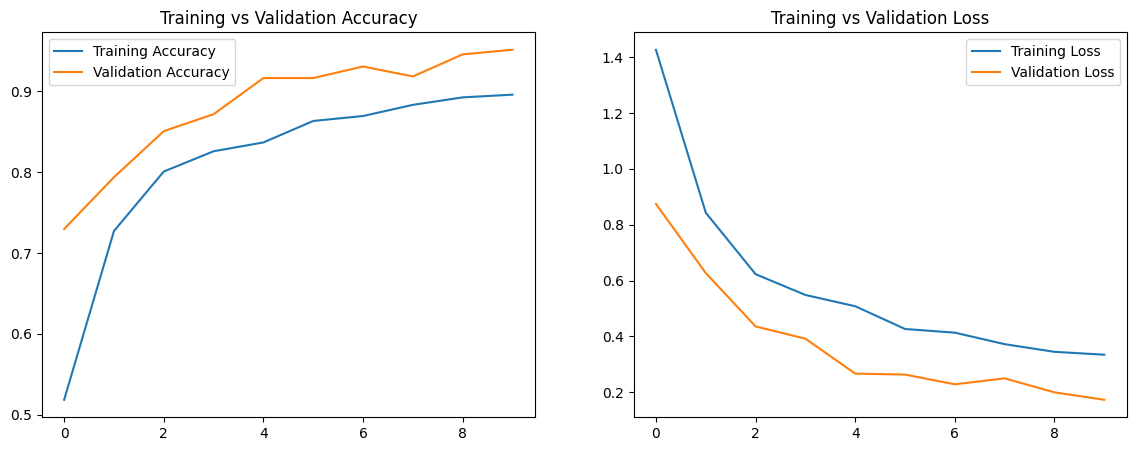

In [23]:
# Plot akurasi dan loss
plt.figure(figsize=(14,5))

# Akurasi
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9502 - loss: 0.1687
Test Accuracy: 94.70%
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


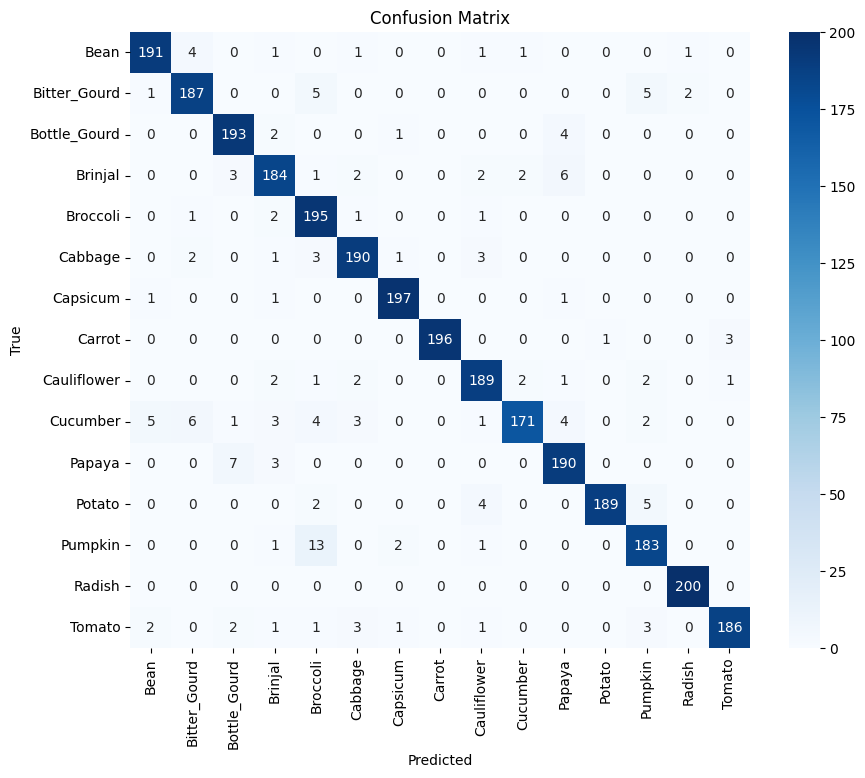

              precision    recall  f1-score   support

        Bean       0.95      0.95      0.95       200
Bitter_Gourd       0.94      0.94      0.94       200
Bottle_Gourd       0.94      0.96      0.95       200
     Brinjal       0.92      0.92      0.92       200
    Broccoli       0.87      0.97      0.92       200
     Cabbage       0.94      0.95      0.95       200
    Capsicum       0.98      0.98      0.98       200
      Carrot       1.00      0.98      0.99       200
 Cauliflower       0.93      0.94      0.94       200
    Cucumber       0.97      0.85      0.91       200
      Papaya       0.92      0.95      0.94       200
      Potato       0.99      0.94      0.97       200
     Pumpkin       0.92      0.92      0.92       200
      Radish       0.99      1.00      0.99       200
      Tomato       0.98      0.93      0.95       200

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95   

In [25]:
# Evaluasi
test_loss, test_accuracy = model_sayur.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Prediksi
y_pred_probs = model_sayur.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes  # asli label numerik

# Label kategori
categories = list(test_data.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=categories))


## Konversi Model

###Saved Model

In [29]:
export_dir = 'saved_model/'
tf.saved_model.save(model_sayur, export_dir)

###TF-Lite

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

os.makedirs('tflite', exist_ok=True)
tflite_model_file = pathlib.Path('tflite/vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

7924

###TF JS

In [31]:
model_sayur.save("model.h5")
!pip install tensorflowjs
!pip uninstall google-cloud-bigquery -y
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
Found existing installation: google-cloud-bigquery 3.31.0
Uninstalling google-cloud-bigquery-3.31.0:
  Successfully uninstalled google-cloud-bigquery-3.31.0
2025-05-05 04:28:21.273539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746419301.293679   2

In [32]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
commun

In [37]:
import zipfile
import os

# Tentukan path ke folder SavedModel Anda
saved_model_dir = '/content/tflite'  # Ganti dengan path folder model Anda

# Tentukan nama file ZIP untuk arsip
zip_filename = '/content/tflite.zip'

# Mengarsipkan folder SavedModel menjadi file ZIP
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Menelusuri seluruh folder dan menambahkan ke file ZIP
    for root, dirs, files in os.walk(saved_model_dir):
        for file in files:
            zipf.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file), saved_model_dir))

print(f"Model telah diarsipkan sebagai {zip_filename}")


Model telah diarsipkan sebagai /content/tflite.zip


## Inference (Optional)